In [1]:
import os
import numpy as np
np.set_printoptions(precision=1)
import nibabel as nib
import json
import matplotlib.image as mpimg
from os.path import join as opj
import matplotlib.pyplot as plt
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nilearn.plotting import plot_anat, plot_epi, view_img, plot_roi
from nipype import Node, MapNode, Workflow, JoinNode  # components to construct workflow
from bids.layout import BIDSLayout  # BIDSLayout object to specify file(s)
from nilearn.image import mean_img, resample_img, resample_to_img
os.environ[ "ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS" ] = "8"

In [2]:
%matplotlib inline
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FEAT, FEATModel, FLIRT, FNIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold, Merge, ApplyWarp, MeanImage, Level1Design)
from nipype.interfaces.afni import Refit, Volreg, SkullStrip, Allineate
from nipype.interfaces.ants import RegistrationSynQuick, Registration, ApplyTransforms
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect

In [3]:
def get_affine(path_to_file):
    return nib.load(path_to_file).affine
def get_voxel_dim(path_to_file):
    return nib.load(path_to_file).header.get_zooms()
def get_shape(path_to_file):
    return nib.load(path_to_file).shape

In [36]:
# Directory where your data set resides.

labels_path = '/data/atlas/scaled_labels.nii.gz'
atlas_path = '/data/atlas/scaled_template.nii.gz'

mouse_dir = '/data/testDS/mouse_main/'

bids_dir = opj(mouse_dir,'bids')

output_dir = opj(mouse_dir, 'output')

working_dir = 'working_dir'

In [37]:
# Create Directory where the data set resides.
import shutil

if os.path.exists(output_dir):
    try:
        shutil.rmtree(output_dir)
    except OSError as e:
        print("Error: %s : %s" % (output_dir, e.strerror))
else:
    os.mkdir(output_dir)

In [38]:
# Creating the layout object for this BIDS data set
layout = BIDSLayout(bids_dir)

subjects = layout.get_subjects()
acquisitions = layout.get_acquisitions()
tasks = layout.get_tasks()
sessions = layout.get_sessions()
runs = layout.get_runs()
print(f"subjects - {subjects}, \nsessions - {sessions},\nacquisitions - {acquisitions}, \ntasks - {tasks}, \nruns - {runs}")

subjects - ['01'], 
sessions - ['FDWHSKR'],
acquisitions - ['FLASH', 'EPI'], 
tasks - ['4W'], 
runs - [4, 5]


In [43]:
#Assigning filenames and JSON randon file for TR
if acquisitions[0] == 'EPI':
    EPI_files = layout.get(subject=subjects, acquisition=acquisitions[0], extensions=['nii.gz'], return_type='file')
    FLASH_files = layout.get(subject=subjects, acquisition=acquisitions[1], extensions=['nii.gz'], return_type='file')
else:
    FLASH_files = layout.get(subject=subjects, acquisition=acquisitions[0], extensions=['nii.gz'], return_type='file')
    EPI_files = layout.get(subject=subjects, acquisition=acquisitions[1], extensions=['nii.gz'], return_type='file')
print(f'Number of functional images: {len(EPI_files)} \nNumber of anatomical images: {len(FLASH_files)}')

Number of functional images: 2 
Number of anatomical images: 1


In [44]:
# Data iterator
# Infosource - a function free node to iterate over the list of subject names
#------------------------------------------FUNC------------------------------------------
infosource_func = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource_func")
infosource_func.iterables = [('subject_id', subjects), ('task_name', tasks)]

func_file = opj('sub-{subject_id}', 'ses-FDWHSKR', 'func', 'sub-{subject_id}_ses-FDWHSKR_task-{task_name}_acq-EPI_run-*_bold.nii.gz')

templates_func = {'func': func_file}
#------------------------------------------ANAT------------------------------------------
infosource_anat = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource_anat")
infosource_anat.iterables = [('subject_id', subjects)]

anat_file = opj('sub-{subject_id}', 'ses-FDWHSKR', 'anat','sub-{subject_id}_ses-FDWHSKR_acq-FLASH_T1w.nii.gz')

templates_anat = {'anat': anat_file}




selectfiles_anat = Node(SelectFiles(templates_anat, 
                               base_directory=bids_dir), name="selectfiles_anat")
selectfiles_func = Node(SelectFiles(templates_func, 
                               base_directory=bids_dir), name="selectfiles_func")

In [45]:
scale = 25
TR=1.0
#----------------------------------MEAN_FUNC------------------------------------------
mean_scale = Node(Refit(in_file = EPI_files[0],
                       deoblique = True,
                       xyzscale = scale),
                  name='mean_scale')

mean_motion_corr = Node(Volreg(num_threads=8,
                               outputtype='NIFTI_GZ'),
                        name='mean_motion_corr')

func_mean_brain_extraction = Node(BET(output_type='NIFTI_GZ'),
                                  mask = True,
                 name='func_mean_brain_extraction')

func_mean2anat_L = Node(FLIRT(  # target: FLASH - weighted
                       dof=6,
                       #cost = 'normmi', # normizied mutual info
                       #interp ='spline',
                       output_type='NIFTI_GZ'), 
                 name="func2anat_L")

func_mean2anat_applywarp = Node(ApplyWarp(),
                               name='func_mean2anat_applywarp')
#---------------------------------------FUNC------------------------------------------

epi_scale = MapNode(Refit(#in_file = EPI_files[0],
                       deoblique = True,
                       xyzscale = scale),
                  name='epi_scale', iterfield=['in_file'])

epi_motion_corr = MapNode(Volreg(num_threads=8,
                               outputtype='NIFTI_GZ'),
                        name='epi_motion_corr', iterfield=['in_file'])

extract = MapNode(ExtractROI(t_min=10, 
                          t_size=-1, 
                          output_type='NIFTI_GZ'),
                 name="extract", iterfield=['in_file'])

slicetimer = MapNode(SliceTimer(index_dir=False,
                             interleaved=True,
                             time_repetition=TR),
                 name="slicetimer", iterfield=['in_file'])

func2anat_applywarp = MapNode(ApplyWarp(),
                               name='func2anat_applywarp', iterfield=['in_file'])

func2atlas_applywarp = MapNode(ApplyWarp(),
                               name='func2atlas_applywarp', iterfield=['in_file'])
#---------------------------------------ANAT------------------------------------------
scaler_anat = Node(Refit(deoblique=True,
                         xyzscale=scale),
                 name = 'scaler_anat')

anat_brain_extraction = Node(BET(output_type='NIFTI_GZ'),
                                  mask = True,
                 name='anat_brain_extraction')


anat2atlas_L = Node(FLIRT(  # target: FLASH - weighted
                       dof=12,
                       cost = 'normmi', # normizied mutual info
                       interp ='spline',
                       reference = atlas_path,
                       output_type='NIFTI_GZ'), 
                 name="anat2atlas_L")


datasink = Node(DataSink(base_directory=output_dir),
               name='datasink')

In [46]:
mean_wf = Workflow(name='mean_wf', base_dir=opj(output_dir, working_dir))

In [47]:
mean_wf.connect([
                    #-----------------------------------MEAN_FUNC-----------------------------------------
                    ( mean_scale, mean_motion_corr,                          [('out_file','in_file')]),
                    ( mean_motion_corr, func_mean_brain_extraction,           [('out_file','in_file')]),
    
                    #------------------------------------FUNC_MEAN2ANAT-----------------------------------
                    ( func_mean_brain_extraction, func_mean2anat_L,           [('out_file','in_file')]),
                    ( anat_brain_extraction, func_mean2anat_L,                [('out_file','reference')]),
                    ( func_mean2anat_L, func_mean2anat_applywarp,             [('out_file','in_file')]),
                    ( anat2atlas_L, func_mean2anat_applywarp,                 [('out_matrix_file','premat')]),
                    ( anat2atlas_L, func_mean2anat_applywarp,                 [('out_file','ref_file')]),
    
                    #---------------------------------------ANAT------------------------------------------
                    ( infosource_anat, selectfiles_anat,                   [('subject_id','subject_id')]),
                    ( selectfiles_anat, scaler_anat,                       [('anat','in_file')]),
                    ( scaler_anat, anat_brain_extraction,                  [('out_file','in_file')]),
                    #------------------------------------ANAT2ATLAS---------------------------------------
                    ( anat_brain_extraction, anat2atlas_L,                 [('out_file','in_file')]),
                    
    
    
                    #---------------------------------------FUNC------------------------------------------
                    ( infosource_func, selectfiles_func,       [('subject_id','subject_id'),('task_name','task_name')]),
                    ( selectfiles_func, epi_scale,             [('func','in_file')]),
                    ( epi_scale, extract,                      [('out_file','in_file')]),
                    ( extract, slicetimer,                     [('roi_file','in_file')]),
                    ( slicetimer, epi_motion_corr,             [('slice_time_corrected_file','in_file')]),
                    ( mean_motion_corr, epi_motion_corr,       [('out_file','basefile')]),
                    #------------------------------------FUNC2ANAT----------------------------------------
                    ( epi_motion_corr, func2anat_applywarp,             [('out_file','in_file')]),
                    ( anat_brain_extraction, func2anat_applywarp,       [('out_file','ref_file')]),
                    ( func_mean2anat_L, func2anat_applywarp,            [('out_matrix_file','premat')]),
                    
                    #------------------------------------FUNC2ATLAS----------------------------------------
                    ( func2anat_applywarp, func2atlas_applywarp,         [('out_file','in_file')]),
                    ( anat2atlas_L, func2atlas_applywarp,                [('out_file','ref_file')]),
                    ( anat2atlas_L, func2atlas_applywarp,                [('out_matrix_file','premat')]),
    
                    #--------------------------------------DATASINK-----------------------------------------
                    ( mean_motion_corr, datasink,              [('out_file',         'mean_func.@mean_motion_corr')]),
                    #( epi_motion_corr,  datasink,              [('out_file','func.@epi_motion_corr')]),
                    ( func_mean_brain_extraction, datasink,    [('out_file',         'mean_func.@mean_brain'),('mask_file', 'mean_func.@brain_mask')]),
                    ( anat_brain_extraction, datasink,          [('out_file',        'anat.@brain'),('mask_file', 'anat.@brain_mask')]),
                    ( anat2atlas_L, datasink,                  [('out_matrix_file',  'anat2atlas_L.@anat2atlas_affine_mtrx')]),
                    ( anat2atlas_L, datasink,                  [('out_file',         'anat2atlas_L.@anat2atlas')]),
                    ( func_mean2anat_L, datasink,             [('out_file',        'mean_func2anat.@mean_func2anat')]),
                    ( func_mean2anat_L, datasink,             [('out_matrix_file', 'mean_func2anat.@mean2anat_affine_mtrx')]),
                    ( func_mean2anat_applywarp, datasink,     [('out_file',        'mean_func2atlas.@mean2atlas')]),
                    ( anat2atlas_L, datasink,                 [('out_matrix_file', 'mean_func2atlas.@anat2atlas_affine_mtrx')]),
                    ( func2anat_applywarp, datasink,          [('out_file',  'func2anat.@')]),
                    ( func2atlas_applywarp, datasink,          [('out_file', 'func2atlas.@')]),
                ])

In [48]:
## Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 #('_run_', 'run-'),
                 ('_task_name_', '_task-'),
                 ('_func2atlas_applywarp', ''),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('_volreg',''),
                 ('.nii.gz_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ('_warp',''),
                ]
#_subject_id_0000004_task_name_25W'
#subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in smooth_kernel]
#substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

210202-05:29:36,977 nipype.workflow INFO:
	 Generated workflow graph: /data/testDS/mouse_main/output/working_dir/mean_wf/graph.png (graph2use=colored, simple_form=True).


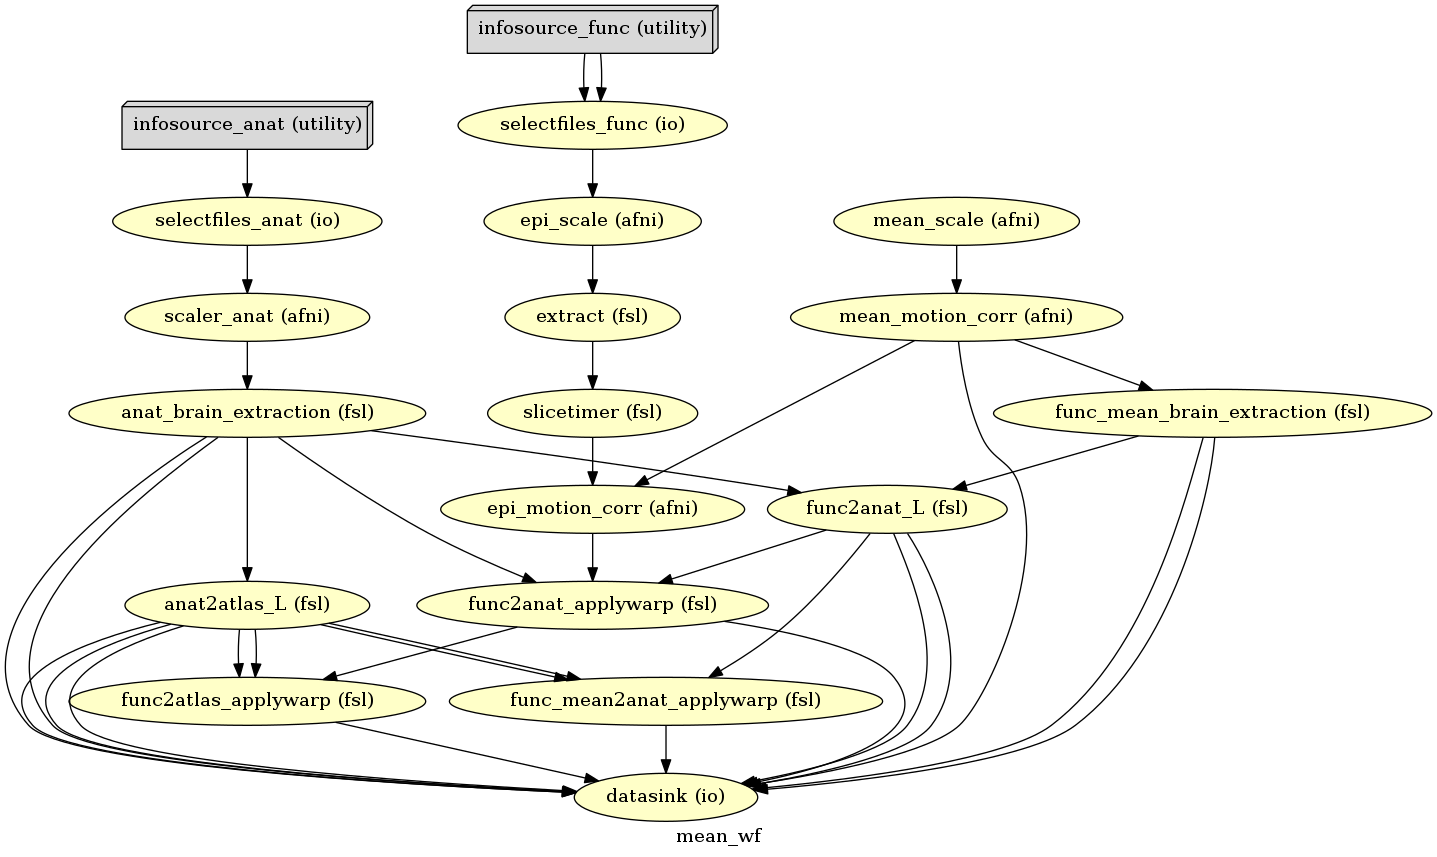

In [49]:
# Create preproc output graph
mean_wf.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(mean_wf.base_dir, 'mean_wf', 'graph.png'))

In [74]:
mean_wf.run('MultiProc', plugin_args={'n_procs': 8})

In [214]:
opj(output_dir,'mean_func')

'/data/testDS/mouse_20210107/output/mean_func'

In [72]:
os.listdir(opj(output_dir))

['func2anat',
 'mean_func',
 'mean_func2atlas',
 'anat',
 'mean_func2anat',
 'anat2atlas_L',
 'func2atlas',
 'working_dir']

In [69]:
#mean_func_path = opj(output_dir,'mean_func',f'sub-0000004_ses-FDWHSKR_task-4BL_acq-EPI_run-8_bold_volreg_brain.nii.gz')
#mf2a_path = opj(output_dir,'mean_func2anat','sub-01', 'sub-01_ses-FDWHSKR_task-4BL_acq-EPI_run-8_bold_brain.nii.gz')
a2atlas_path = opj(output_dir,'anat2atlas_L','sub-01','sub-01_ses-FDWHSKR_acq-FLASH_T1w_brain.nii.gz')
#anat_brain_path = opj(output_dir,'anat','sub-0000004','sub-0000004_ses-FDWHSKR_acq-FLASH_T1w_brain.nii.gz')
#a2a_affine_path = opj(output_dir,'anat2atlas_L','sub-0000004','sub-0000004_ses-FDWHSKR_acq-FLASH_T1w_brain_flirt.mat')
mf2atlas_path = opj(output_dir,'mean_func2atlas','sub-01','sub-01_ses-FDWHSKR_task-4W_acq-EPI_run-4_bold_brain.nii.gz')
#func2anat_path = opj(output_dir,'func2anat','sub-0000004_task-4BL','sub-0000004','_func2anat_applywarp3','sub-0000004_ses-FDWHSKR_task-4BL_acq-EPI_run-22_bold.nii.gz')
#func2atlas_path =opj(output_dir,'func2atlas','sub-01','sub-01','_func2atlas_applywarp1','sub-0000004_ses-FDWHSKR_task-25W_acq-EPI_run-25_bold.nii.gz')

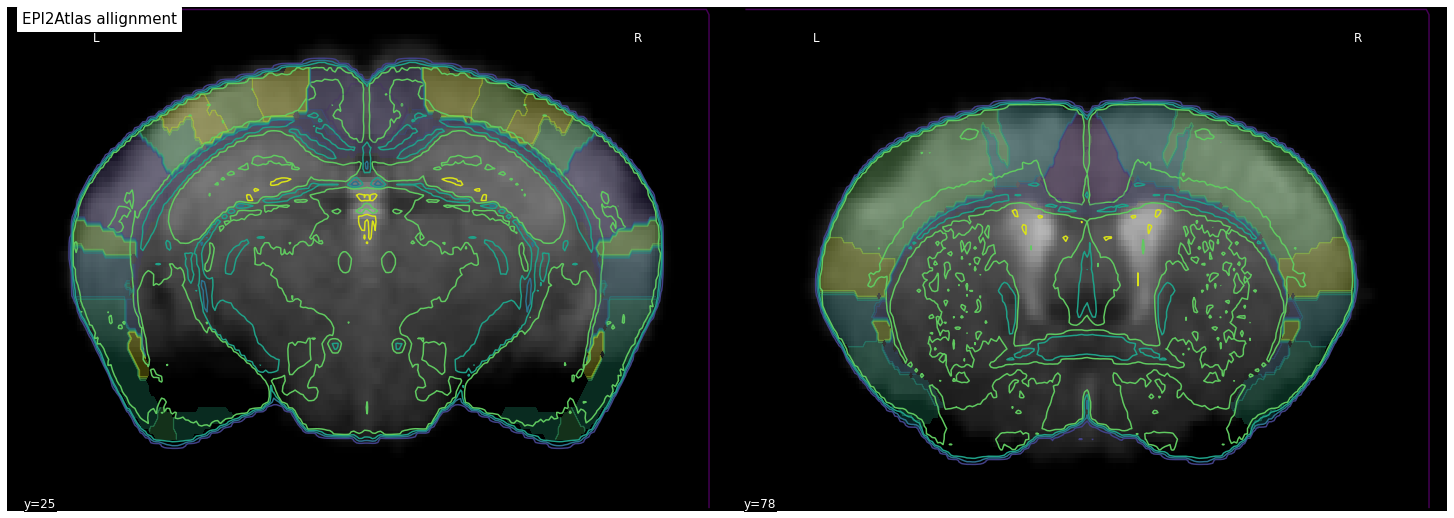

In [70]:
fig = plt.figure(figsize=(20,7))
display = plot_anat(mf2atlas_path, display_mode='y', cut_coords=[25, 78], figure=fig, title="EPI2Atlas allignment")
display.add_contours(atlas_path, levels=np.linspace(1,np.max(nib.load(atlas_path).dataobj),7))
#display.add_contours(a2a_path, levels=np.linspace(1,np.max(nib.load(a2a_path).dataobj),7))
#display.add_contours(mf2atlas_path,levels=np.linspace(1,np.max(nib.load(mf2a_path).dataobj),17), alpha=0.7, filled=True)
display.add_contours(labels_path, filled=True, alpha=0.25)
display.annotate('H')

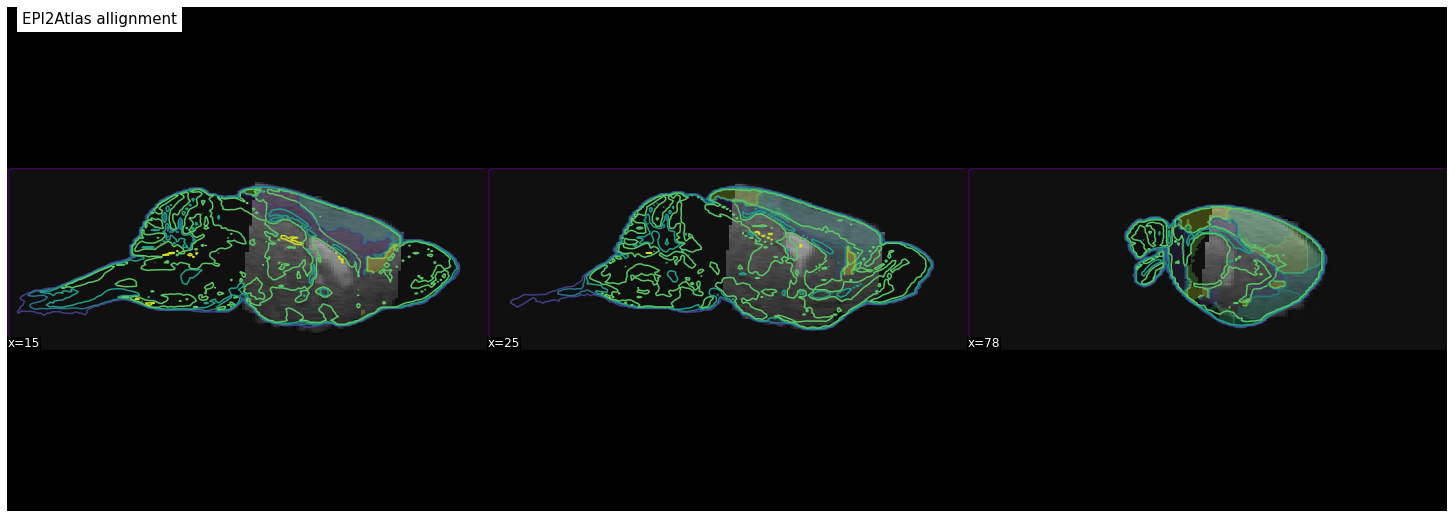

In [59]:
fig = plt.figure(figsize=(20,7))
display = plot_anat(a2atlas_path, display_mode='x', cut_coords=[15, 25, 78], figure=fig, title="EPI2Atlas allignment")
display.add_contours(atlas_path, levels=np.linspace(1,np.max(nib.load(atlas_path).dataobj),7))
#display.add_contours(a2a_path, levels=np.linspace(1,np.max(nib.load(a2a_path).dataobj),7))
#display.add_contours(mf2atlas_path,levels=np.linspace(1,np.max(nib.load(mf2a_path).dataobj),17), alpha=0.7, filled=True)
display.add_contours(labels_path, filled=True, alpha=0.25)
display.annotate('H')

In [156]:
#LVL-1 analysis
from nipype.interfaces.spm import EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.algorithms.modelgen import SpecifyModel

In [157]:
output_dir_1lvl = opj(output_dir,'output_dir_1lvl')

In [158]:
#Model specification for 1-st LVL analysis
from nipype.interfaces.base import Bunch
import csv

tsv_path = opj(output_dir,'output.tsv')

conditions = ['whisker']
event_onsets = 40
durations = 20

subject_info = Bunch(conditions=conditions,
                     onsets = event_onsets,
                     durations = durations)

with open(tsv_path, 'w', newline='') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    tsv_writer.writerow(['onset', 'duration', 'weight', 'trial_type'])
    tsv_writer.writerow([event_onsets, durations, 1, conditions])

In [159]:
## Defining contrasts
cont01 = ['whisker',        'T', conditions, [1]]
#cont02 = ['activation',     'F', conditions]
contrast_list = [cont01]

In [160]:
conditions

['whisker']

In [161]:
infosource_func2atlas = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource_func2atlas")
infosource_func2atlas.iterables = [('subject_id', subjects), ('task_name', tasks)]

f2a_file = opj(output_dir, 'func2atlas', 'sub-{subject_id}_task-{task_name}', 'sub-{subject_id}', '_func2atlas_applywarp*',
               'sub-{subject_id}_ses-FDWHSKR_task-{task_name}_acq-EPI_run-*_bold.nii.gz')

templates_f2a = {'func': f2a_file}
#------------------------------------------ANAT------------------------------------------
infosource_anat2atlas = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource_anat2atlas")
infosource_anat2atlas.iterables = [('subject_id', subjects)]

a2a_file = opj(output_dir, 'anat2atlas_L', 'sub-{subject_id}','sub-{subject_id}_ses-FDWHSKR_acq-FLASH_T1w_brain.nii.gz')

templates_a2a = {'anat': a2a_file}

#opj(output_dir,'func2atlas','sub-0000004_task-25W','sub-0000004','_func2atlas_applywarp7','sub-0000004_ses-FDWHSKR_task-25W_acq-EPI_run-25_bold.nii.gz')
#opj(output_dir,'anat2atlas_L','sub-0000004','sub-0000004_ses-FDWHSKR_acq-FLASH_T1w_brain.nii.gz')

selectfiles_a2a = Node(SelectFiles(templates_a2a, 
                               base_directory=bids_dir), name="selectfiles_anat")
selectfiles_f2a = Node(SelectFiles(templates_f2a, 
                               base_directory=bids_dir), name="selectfiles_func")

In [162]:
#Mask 
func_mask = Node(BET(in_file = mf2atlas_path,
                           output_type='NIFTI_GZ'),
                           mask = True,
                 name='func_mask')



# masking the fMRI with a brain mask
applymask = MapNode(fsl.ApplyMask(),
                 name='applymask', iterfield=['in_file'])


# model specification
modelspec = MapNode(SpecifyModel(subject_info=subject_info,
                                       input_units='secs',
                                       time_repetition=TR,
                                       high_pass_filter_cutoff=100),
                 name="modelspec", iterfield=['functional_runs'])

# first-level design
level1design = MapNode(Level1Design(bases={'dgamma':{'derivs': True}},
                                     interscan_interval=TR,
                                     model_serial_correlations=True,
                                     contrasts=contrast_list),
                    name="level1design", iterfield=['session_info'])


# creating all the other files necessary to run the model
modelgen = MapNode(FEATModel(),
                name='modelgen', iterfield=['fsf_file','ev_files'])



# then running through FEAT
feat = MapNode(FEAT(),
            name="feat", iterfield=['fsf_files'])


# creating datasink to collect outputs
datasink = Node(DataSink(base_directory=output_dir_1lvl),
                name='datasink')

In [163]:
# creating the workflow
firstLevel = Workflow(name="Level1_FingerFootLips", base_dir=output_dir_1lvl)

# connecting nodes
firstLevel.connect(infosource_func2atlas, 'subject_id', selectfiles_f2a, 'subject_id')
firstLevel.connect(infosource_func2atlas, 'task_name', selectfiles_f2a, 'task_name')
firstLevel.connect(selectfiles_f2a, 'func', applymask, 'in_file')
firstLevel.connect(func_mask, 'mask_file', applymask, 'mask_file')
firstLevel.connect(applymask, 'out_file', modelspec, 'functional_runs')
firstLevel.connect(modelspec, 'session_info', level1design, 'session_info')
firstLevel.connect(level1design, 'fsf_files', modelgen, 'fsf_file')
firstLevel.connect(level1design, 'ev_files', modelgen, 'ev_files')
firstLevel.connect(level1design, 'fsf_files', feat, 'fsf_file')
firstLevel.connect(feat, 'feat_dir', datasink, 'feat_dir')
firstLevel.connect(applymask, 'out_file', datasink, 'Level1_out_file')

210107-05:24:38,680 nipype.workflow INFO:
	 Generated workflow graph: /data/testDS/mouse_many/output/output_dir_1lvl/Level1_FingerFootLips/graph_orig.png (graph2use=orig, simple_form=True).


(-0.5, 588.5, 634.5, -0.5)

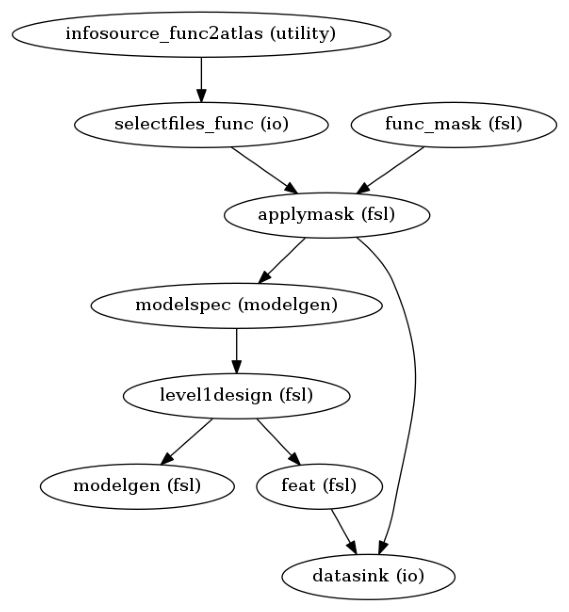

In [164]:
# writing out graphs
firstLevel.write_graph(graph2use='orig', dotfilename='graph_orig.dot')

# showing the graph
plt.figure(figsize=[11,11])
img=mpimg.imread(os.path.join(output_dir_1lvl,"Level1_FingerFootLips","graph_orig.png"))
imgplot = plt.imshow(img)
plt.axis('off')

In [73]:
# running the workflow
#firstLevel.run()